# 📌 Final Phase 1 – Project Setup & Introduction  
## 🧠 Customer Feedback Analyzer

---

## 📝 Project Goal  
Analyze customer reviews using **Natural Language Processing (NLP)** to:  
- Identify key topics being discussed  
- Summarize customer feedback into concise, human-readable form  

💡 This helps businesses **quickly understand customer sentiment & pain points** at scale.

---

## 🎯 Real-World Applications  
- 🛒 **E-commerce:** Detect pain points like *late delivery*, *damaged items*  
- 🏨 **Hotel/Travel:** Group praise/complaints like *clean rooms*, *noisy AC*  
- 🛠 **Product Feedback:** Spot features customers praise or dislike  

---

## 📊 Dataset  
We use the **Amazon Fine Food Reviews** dataset containing long-form food product reviews from Amazon.  

📁 **Kaggle link:** [Amazon Fine Food Reviews](https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews)  

**Each review contains:**  
- Product info  
- User rating  
- Review summary  
- Full review text *(focus of this project)*  

---

## 🔧 Tech Stack  
- **Text Preprocessing:** `nltk`, `spacy`  
- **Topic Modeling:** `BERTopic` / `LDA`  
- **Summarization:** `TextRank`, `T5`, `BART`  
- **Visualization:** `matplotlib`, `seaborn`, `wordcloud`  
- **(Optional) UI:** `Streamlit`


2️⃣ Library Installation

In [1]:
# ✅ Install all required libraries
!pip install -q pandas numpy matplotlib seaborn nltk spacy gensim wordcloud
!pip install -q bertopic sentence-transformers
!pip install -q transformers
!python -m spacy download en_core_web_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 67.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


3️⃣ Load Dataset from Google Drive

In [2]:
# 📂 Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 📂 Define base path
data_path = '/content/drive/MyDrive/datasets/amazon-fine-food-reviews'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


4️⃣ Load CSV File

In [3]:
import pandas as pd

csv_path = f"{data_path}/Reviews.csv"

# ✅ Load CSV into DataFrame
df = pd.read_csv(csv_path)
print("✅ Reviews.csv loaded. Shape:", df.shape)

# 📌 Preview first 5 rows
df.head()


✅ Reviews.csv loaded. Shape: (568454, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


5️⃣ Load SQLite File (Optional)

In [4]:
import sqlite3

sqlite_path = f"{data_path}/database.sqlite"

# ✅ Connect and load SQLite
conn = sqlite3.connect(sqlite_path)
query = "SELECT * FROM Reviews"
sqlite_df = pd.read_sql_query(query, conn)
print("✅ database.sqlite loaded. Shape:", sqlite_df.shape)

conn.close()


✅ database.sqlite loaded. Shape: (568454, 10)


6️⃣ Load Hashes File (Optional)

In [5]:
hashes_path = f"{data_path}/hashes.txt"

with open(hashes_path, 'r') as file:
    hashes = file.readlines()

print(f"✅ hashes.txt loaded. Total hashes: {len(hashes)}")


✅ hashes.txt loaded. Total hashes: 7


# 📌 Final Phase 2 – Text Preprocessing  
## 🔄 Preparing Reviews for Topic Modeling & Summarization  

---

## 🛠 Objective  
Transform raw review text into a **clean, structured format** ready for NLP tasks.  

---

## 🧹 Preprocessing Steps  
1. **Lowercasing** – Standardizes text format for consistency.  
2. **Removing punctuation & special characters** – Cleans out noise.  
3. **Removing stopwords** – Using combined **NLTK** & **spaCy** lists for better coverage.  
4. **Lemmatization** – Reduces words to their base form (*running* → *run*).  
5. **Removing duplicates & empty reviews** – Keeps only valid and meaningful data.  

💡 **Note:** We initially process a **sample of 5,000 reviews** for faster experimentation, with the option to scale up later.

---

## 📝 Example  
**Original Review:**  
> "This product was AMAZING! Delivered early, but the taste was horrible..."  

**Cleaned Review:**  
> `"product amaze deliver early taste horrible"`


📍 Step 1 – Initial Cleanup

In [6]:
# Keep only relevant columns and drop NaN/duplicate reviews
df = df[['Score', 'Text']].dropna()
df.drop_duplicates(subset="Text", inplace=True)
print("✅ After dropping nulls/duplicates:", df.shape)


✅ After dropping nulls/duplicates: (393579, 2)


📍 Step 2 – Install & Import NLP Tools

In [7]:
import re
import nltk
import spacy
from nltk.corpus import stopwords

# Download stopwords for NLTK
nltk.download('stopwords')

# Load spaCy model
nlp = spacy.load('en_core_web_sm')

# Create stopwords set
stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


📍 Step 3 – Define Text Cleaning Function

In [8]:
def clean_text(text):
    """Cleans and lemmatizes review text."""
    if not isinstance(text, str) or len(text.strip()) == 0:
        return ""
    try:
        # Lowercase
        text = text.lower()
        # Remove punctuation, numbers & special characters
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        # Tokenize, remove stopwords, lemmatize
        doc = nlp(text)
        cleaned = [
            token.lemma_ for token in doc
            if token.text not in stop_words
            and not token.is_stop
            and len(token.text) > 2
        ]
        return ' '.join(cleaned) if cleaned else ""
    except Exception as e:
        print(f"Error processing text: {e}")
        return ""


📍 Step 4 – Apply Cleaner to a Subset

In [9]:
# Sample subset for faster processing
sample_size = 5000
df_cleaned = df.sample(sample_size, random_state=42).copy()

# Apply text cleaning
df_cleaned['clean_text'] = df_cleaned['Text'].apply(clean_text)

# Preview cleaned text
df_cleaned[['Text', 'clean_text']].head(5)


,Text,clean_text
508413,I have tried just about every gluten free past...,try gluten free pasta available hand good riso...
351680,I routinely purchase my dog treats through Ama...,routinely purchase dog treat amazon convenienc...
206063,I bought this product and love it. I have deci...,buy product love decide buy flour future regre...
129501,I've been bouncing around from one brand of gr...,bounce brand green tea time find budget price ...
9569,I get these for $4.34 at my local health food ...,local health food store price suck well tastin...


📍 Step 5 – Filter Short or Empty Cleaned Reviews

In [10]:
df_cleaned = df_cleaned[df_cleaned['clean_text'].str.strip().str.len() > 10]
print("✅ Final cleaned sample shape:", df_cleaned.shape)


✅ Final cleaned sample shape: (5000, 3)


📊 Step 6 – Word Cloud of Cleaned Reviews

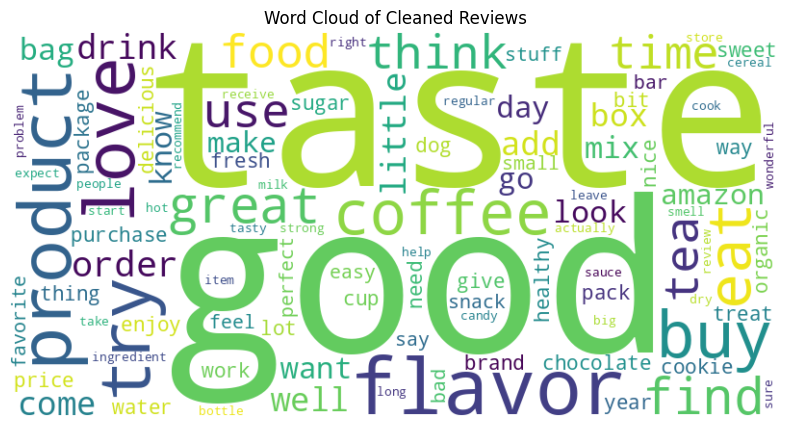

In [11]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all cleaned reviews
all_cleaned_text = ' '.join(df_cleaned['clean_text'])

# Generate word cloud
wordcloud = WordCloud(
    width=800, height=400,
    background_color='white',
    max_words=100
).generate(all_cleaned_text)

# Display
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Word Cloud of Cleaned Reviews")
plt.axis('off')
plt.show()


📊 Step 7 – Review Length Distribution

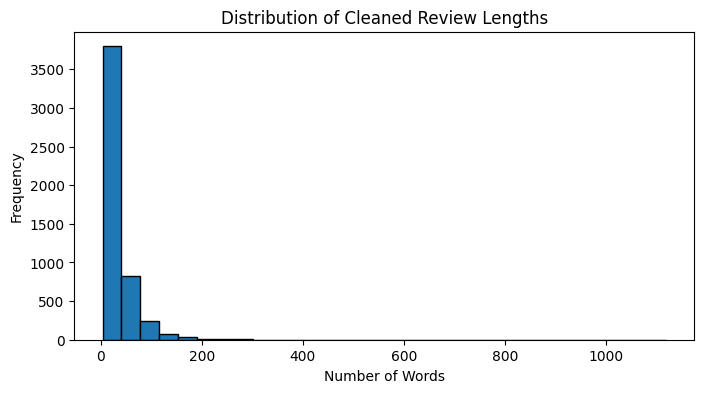

In [12]:
import pandas as pd

# Calculate review lengths
review_lengths = df_cleaned['clean_text'].str.split().apply(len)

# Create histogram
plt.figure(figsize=(8, 4))
plt.hist(review_lengths, bins=30, edgecolor='black')
plt.title("Distribution of Cleaned Review Lengths")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()


# 📌 Final Phase 3 – Topic Modeling with BERTopic  
## 🧠 Extracting Key Themes from Customer Reviews  

---

## 🎯 Objective  
Identify major discussion topics within **5,000 cleaned customer reviews** using **BERTopic**, a transformer-based topic modeling technique.

---

## ⚙️ How BERTopic Works  
1. **Dense Vector Embeddings** – Each review is converted into a numerical vector using transformer models.  
2. **Clustering** – Similar reviews are grouped together based on their embeddings.  
3. **Keyword Extraction** – For each cluster, the most representative keywords are selected.  

---

## 🧩 Example – Top Topics  
| Topic ID | Count | Keywords |
|----------|-------|----------|
| 0 | 234 | taste, product, like, good, flavor |
| 1 | 189 | delivery, late, packaging, order |
| 2 | 102 | price, value, money, expensive |

📌 *The model discovered **N** distinct topics across the dataset.*  

---

## 📊 Visualizations  
- **`topic_model.visualize_topics()`** – Interactive 2D topic map for exploring clusters.  
- **`topic_model.get_topic_info()`** – Table view of topic IDs, counts, and top keywords.  


📍 Step 1 – Import BERTopic & Vectorizer



In [13]:
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer


📍 Step 2 – Prepare Documents

In [14]:
# Convert cleaned reviews to list
documents = df_cleaned['clean_text'].tolist()


📍 Step 3 – Initialize and Fit BERTopic

In [15]:
# Create BERTopic model
topic_model = BERTopic(language="english", verbose=True)

# Fit model on cleaned documents
topics, probs = topic_model.fit_transform(documents)


2025-08-09 08:03:15,966 - BERTopic - Embedding - Transforming documents to embeddings.


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/157 [00:00<?, ?it/s]

2025-08-09 08:04:58,463 - BERTopic - Embedding - Completed ✓
2025-08-09 08:04:58,464 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-08-09 08:05:23,657 - BERTopic - Dimensionality - Completed ✓
2025-08-09 08:05:23,659 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-08-09 08:05:23,817 - BERTopic - Cluster - Completed ✓
2025-08-09 08:05:23,824 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-08-09 08:05:24,005 - BERTopic - Representation - Completed ✓


📍 Step 4 – View Summary of Topics

In [16]:
# Get topic information
topic_info = topic_model.get_topic_info()
topic_info.head(10)  # Show top 10 topics


,Topic,Count,Name,Representation,Representative_Docs
0,-1,1546,-1_product_taste_good_like,"[product, taste, good, like, flavor, buy, grea...",[find oatmeal year ago fall love easy convenie...
1,0,542,0_coffee_cup_kcup_roast,"[coffee, cup, kcup, roast, espresso, pod, flav...",[good cup coffee smooth bitter taste like stro...
2,1,343,1_tea_green_drink_bag,"[tea, green, drink, bag, cup, matcha, taste, f...",[delicious sweet spicy tea big tea drinker dri...
3,2,342,2_dog_treat_food_chew,"[dog, treat, food, chew, bone, love, toy, pet,...",[veterinary student love chew dog well quality...
4,3,163,3_sauce_hot_taco_spicy,"[sauce, hot, taco, spicy, chili, curry, pepper...",[taco bell bold creamy chipotle sauce taco bel...
5,4,123,4_order_shipping_price_product,"[order, shipping, price, product, receive, pay...",[order product year favorite good price well s...
6,5,111,5_cat_food_eat_litter,"[cat, food, eat, litter, can, kitten, feed, ve...",[cat love can cat food food look smell human e...
7,6,109,6_cookie_chocolate_cake_oreo,"[cookie, chocolate, cake, oreo, soft, chip, ta...",[big quaker oats brand fan cookie horrible opi...
8,7,85,7_cereal_granola_oatmeal_breakfast,"[cereal, granola, oatmeal, breakfast, flake, c...",[think cereal way hard taste like cardboard li...
9,8,84,8_chocolate_cocoa_dark_bar,"[chocolate, cocoa, dark, bar, taste, almond, r...",[huge chocolate fan love taste milk chocolate ...


📍 Step 5 – View Keywords for a Specific Topic

In [17]:
# Example: Show top words for Topic 0
topic_model.get_topic(0)


[('coffee', 0.07455998626624426),
 ('cup', 0.027117697864592755),
 ('kcup', 0.02333975774214945),
 ('roast', 0.021567165963716804),
 ('espresso', 0.017397827518704032),
 ('pod', 0.016133672338944954),
 ('flavor', 0.015829351904695005),
 ('french', 0.014666974853586322),
 ('blend', 0.014179406803903087),
 ('brew', 0.013969557605666823)]

📍 Step 6 – Visualize Topics (Interactive)

In [18]:
# Create interactive topic visualization
topic_model.visualize_topics()


📍 Step 7 – Assign Topics to DataFrame

In [19]:
# Save assigned topic ID to dataframe
df_cleaned['Topic'] = topics
df_cleaned[['clean_text', 'Topic']].head()


,clean_text,Topic
508413,try gluten free pasta available hand good riso...,22
351680,routinely purchase dog treat amazon convenienc...,2
206063,buy product love decide buy flour future regre...,18
129501,bounce brand green tea time find budget price ...,1
9569,local health food store price suck well tastin...,32


📍 Step 8 – Save Model

In [20]:
# Save the trained BERTopic model
topic_model.save("bertopic_model")


2025-08-09 08:05:28,763 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


# 📌 Final Phase 4 – Review Summarization  
## 📝 Turning Detailed Feedback into Concise Insights  

---

## 🎯 Objective  
Condense lengthy customer reviews into short, meaningful summaries so that businesses can **quickly grasp the key points** from each topic identified in Phase 3.

---

## ⚙️ Methods Used  

1. **TextRank (Extractive Summarization)**  
   - Unsupervised algorithm  
   - Quickly extracts the most important sentences from the text  
   - Ideal for summarizing large volumes of reviews  

2. **BART Transformer (Abstractive Summarization)**  
   - Pretrained transformer model  
   - Generates **human-like rephrased summaries** rather than just extracting sentences  
   - Captures context and tone better  

---

## 🔹 Example  

**Original Review:**  
> "I ordered this product two weeks ago but it still hasn’t arrived. Very disappointed with the packaging and tracking..."  

**Generated Summary:**  
> "Late delivery and poor packaging experience."  


📍 Step 1 – Group Reviews by Topics

In [21]:
# Create DataFrame mapping reviews to topics
df_topic = pd.DataFrame({
    'Review': documents,
    'Topic': topics
})

# View topic info
topic_info = topic_model.get_topic_info()
topic_info.head()


,Topic,Count,Name,Representation,Representative_Docs
0,-1,1546,-1_product_taste_good_like,"[product, taste, good, like, flavor, buy, grea...",[find oatmeal year ago fall love easy convenie...
1,0,542,0_coffee_cup_kcup_roast,"[coffee, cup, kcup, roast, espresso, pod, flav...",[good cup coffee smooth bitter taste like stro...
2,1,343,1_tea_green_drink_bag,"[tea, green, drink, bag, cup, matcha, taste, f...",[delicious sweet spicy tea big tea drinker dri...
3,2,342,2_dog_treat_food_chew,"[dog, treat, food, chew, bone, love, toy, pet,...",[veterinary student love chew dog well quality...
4,3,163,3_sauce_hot_taco_spicy,"[sauce, hot, taco, spicy, chili, curry, pepper...",[taco bell bold creamy chipotle sauce taco bel...


📍 Step 2 – Select Top N Topics (Ignore Outliers)

In [22]:
top_n = 5  # Number of topics to summarize
top_topics = df_topic[df_topic['Topic'] != -1]['Topic'].value_counts().nlargest(top_n).index


📍 Step 3 – Install & Import Sumy

In [23]:
!pip install -q sumy

from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.text_rank import TextRankSummarizer


  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.3/97.3 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 66.1 MB/s eta 0:00:00


📍 Step 4 – Define TextRank Summarizer Function

In [24]:
def text_rank_sumy(text, num_sentences=5):
    parser = PlaintextParser.from_string(text, Tokenizer("english"))
    summarizer = TextRankSummarizer()
    summary = summarizer(parser.document, num_sentences)
    return ' '.join(str(sentence) for sentence in summary)


📍 Step 5 – Apply TextRank to Each Topic

In [25]:
for topic_num in top_topics:
    print(f"\n🔹 Topic {topic_num}")
    topic_reviews = df_topic[df_topic['Topic'] == topic_num]['Review'].tolist()
    combined_text = ' '.join(topic_reviews)

    try:
        summary = text_rank_sumy(combined_text, num_sentences=5)
        print("📌 Summary:\n", summary)
    except:
        print("❌ Not enough content to summarize.")



🔹 Topic 0
❌ Not enough content to summarize.

🔹 Topic 1
❌ Not enough content to summarize.

🔹 Topic 2
❌ Not enough content to summarize.

🔹 Topic 3
❌ Not enough content to summarize.

🔹 Topic 4
❌ Not enough content to summarize.


📍 Step 6 – Load Hugging Face Summarizer

In [26]:
from transformers import pipeline

summarizer = pipeline("summarization", model="sshleifer/distilbart-cnn-12-6")


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

Device set to use cpu


📍 Step 7 – Apply BART to Each Topic

In [27]:
for topic_num in top_topics:
    print(f"\n🔹 Topic {topic_num}")
    topic_reviews = df_topic[df_topic['Topic'] == topic_num]['Review'].tolist()

    # Limit to avoid token overflow
    combined_text = ' '.join(topic_reviews[:5])

    if combined_text.strip():
        summary = summarizer(
            combined_text,
            max_length=100,
            min_length=30,
            do_sample=False
        )[0]['summary_text']
        print("📌 Summary:\n", summary)
    else:
        print("❌ Not enough content to summarize.")



🔹 Topic 0
📌 Summary:
  Mom coffee come deep dark flavor absolutely yummy dinner manage revive adult huge thanksgiving mealbr star advice try affordable coffee magic coffee touch mere mortal like stick idiot proof brand buy experimental canbr love dark roast coffee husband hate bitterness difference taste coffee maker kitchen lightmedium roast favorite espresso french roast .

🔹 Topic 1
📌 Summary:
  bounce brand green tea time find budget price range supermarket brand specialty offering costco trader joe yes wonderful exotic exotic green talk everyday stuff feel guilty husband enjoy favorite lipton ubiquitous yellow box cheap green cost considerably ounce ounce default orange pekoebr think finally find stuff .

🔹 Topic 2
📌 Summary:
  amazon convenience cost quality unfortunately order beefeater duck fillet jar dry powdery dog eat augment snack depend on amazon quality control isclacke malamute mix love merrick flossie night time ritual help evening business hurry inside evening know fl

# 📌 Final Phase 5 – Topic-wise Review Sentiment & Summarization  
## 📊 Connecting Topics with Sentiment for Actionable Insights  

---

## 🎯 Objective  
Combine the power of **topic modeling**, **summarization**, and **sentiment analysis** to understand **what** customers are talking about and **how** they feel about it.

---

## ⚙️ Steps  

1. **Merge BERTopic Topics with BART Summaries**  
   - Each review gets a topic label and a short summary.  

2. **Sentiment Analysis per Review**  
   - Classify each review as **Positive**, **Negative**, or **Neutral**.  

3. **Aggregate Sentiment per Topic**  
   - Calculate the percentage of positive vs. negative feedback for each topic.  

4. **Visualize Results**  
   - Use bar charts and pie charts for an at-a-glance understanding of customer mood per topic.  

---

## 🔹 Example Output  

| Topic | Keywords                          | Sample Summaries                          |
|-------|-----------------------------------|--------------------------------------------|
| 0     | taste, flavor, love               | "Tastes amazing. Great flavor!"            |
| 1     | delivery, late, packaging         | "Delivery was delayed. Poor packaging."    |

---


📍 Step 1 – Install & Import Sentiment Analysis Tools

In [28]:
!pip install -q textblob
from textblob import TextBlob


📍 Step 2 – Define Sentiment Function

In [29]:
def get_sentiment(text):
    """Returns polarity score (-1 negative to +1 positive)."""
    return TextBlob(text).sentiment.polarity

# Apply sentiment to each review
df_topic['Sentiment'] = df_topic['Review'].apply(get_sentiment)


📍 Step 3 – Aggregate Sentiment by Topic

In [30]:
topic_sentiment = (
    df_topic
    .groupby('Topic')['Sentiment']
    .agg(['mean', 'count'])
    .reset_index()
)

topic_sentiment.columns = ['Topic', 'Avg Sentiment', 'Review Count']

# Sort by sentiment score
topic_sentiment.sort_values('Avg Sentiment', ascending=False, inplace=True)
topic_sentiment.head()


,Topic,Avg Sentiment,Review Count
64,63,0.513843,10
43,42,0.442840,18
50,49,0.427611,15
62,61,0.407265,11
40,39,0.394627,21


📍 Step 4 – Visualize Average Sentiment per Topic

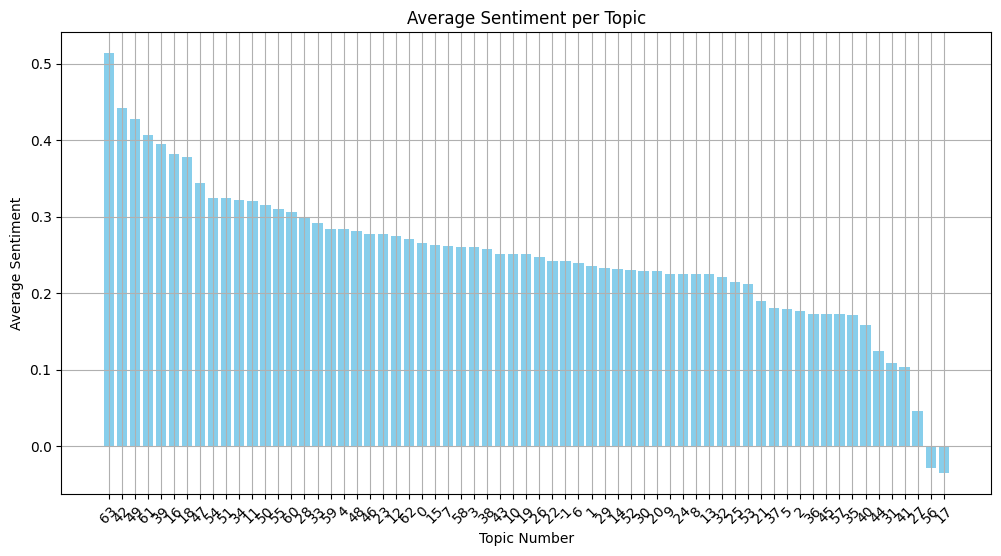

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.bar(topic_sentiment['Topic'].astype(str),
        topic_sentiment['Avg Sentiment'],
        color='skyblue')
plt.xlabel('Topic Number')
plt.ylabel('Average Sentiment')
plt.title('Average Sentiment per Topic')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


📍 Step 5 – Label Topics for Better Interpretation

In [32]:
# Get topic names from BERTopic
topic_names = topic_model.get_topic_info()

# Merge topic labels with sentiment results
topic_sentiment = topic_sentiment.merge(
    topic_names[['Topic', 'Name']],
    on='Topic',
    how='left'
)

topic_sentiment.head()


,Topic,Avg Sentiment,Review Count,Name
0,63,0.513843,10,63_fresh_price_great_ballpark
1,42,0.442840,18,42_pancake_recipe_egg_muffin
2,49,0.427611,15,49_cracker_cheese_millenium_finn
3,61,0.407265,11,61_candy_cherry_flavor_delicious
4,39,0.394627,21,39_snack_crunchy_crunch_kashis


📌 Step 6: Combine Topics, Keywords, Sentiment & Sample Summaries

In [33]:
# ✅ Step 6: Combine Topics, Keywords, Sentiment & Sample Summaries

# Get topic keywords
topic_keywords = {}
for topic_num in topic_model.get_topics():
    words = [word for word, _ in topic_model.get_topic(topic_num)]
    topic_keywords[topic_num] = words[:5]  # top 5 keywords

# Get one sample summary per topic (using first review for simplicity — can be improved)
sample_summaries = {}
for topic_num in df_topic['Topic'].unique():
    topic_reviews = df_topic[df_topic['Topic'] == topic_num]['Review'].tolist()
    if topic_reviews:
        combined_text = ' '.join(topic_reviews[:5])
        if combined_text.strip():
            try:
                summary = summarizer(combined_text, max_length=50, min_length=15, do_sample=False)[0]['summary_text']
            except:
                summary = "Summary not available"
        else:
            summary = "No content"
        sample_summaries[topic_num] = summary

# Merge everything into one DataFrame
final_topic_table = topic_sentiment.copy()
final_topic_table['Keywords'] = final_topic_table['Topic'].map(topic_keywords)
final_topic_table['Sample Summary'] = final_topic_table['Topic'].map(sample_summaries)

# Sort by Review Count for clarity
final_topic_table = final_topic_table.sort_values(by='Review Count', ascending=False)

# Display the table
import pandas as pd
pd.set_option('display.max_colwidth', None)
final_topic_table


,Topic,Avg Sentiment,Review Count,Name,Keywords,Sample Summary
35,-1,0.241863,1546,-1_product_taste_good_like,"[product, taste, good, like, flavor]",Poptart taste fresher one get grocery store year good date stamp box . recommend use use bag time work flavor incredible sweet minty minty expect like overwhelmed good actually bit expensive treat tasty treat .
24,0,0.266177,542,0_coffee_cup_kcup_roast,"[coffee, cup, kcup, roast, espresso]",Mom coffee come deep dark flavor absolutely yummy dinner manage revive adult huge thanksgiving mealbr star advice try affordable coffee magic coffee touch mere mortal like stick idiot proof brand buy experimental canbr love dark roast coffee husband hate bitterness difference taste coffee
37,1,0.235689,343,1_tea_green_drink_bag,"[tea, green, drink, bag, cup]",bounce brand green tea time find budget price range supermarket brand specialty offering costco trader joe yes wonderful exotic exotic green talk everyday stuff feel guilty husband enjoy favorite lipton ubiquitous yellow box cheap green cost considerably ounce ounce default orange pekoe
53,2,0.177579,342,2_dog_treat_food_chew,"[dog, treat, food, chew, bone]",amazon convenience cost quality unfortunately order beefeater duck fillet jar dry powdery dog eat augment snack depend amazon quality control isclacke malamute mix love merrick flossie night time ritual help evening business hurry
28,3,0.261037,163,3_sauce_hot_taco_spicy,"[sauce, hot, taco, spicy, chili]",hot sauce melindas naga jolokia is one of the world's favorite hot sauce forms . Find sause marinara sauce dinner experiencebr try sauce year give .
...,...,...,...,...,...,...
63,56,-0.028167,12,56_pill_pocket_medication_spit,"[pill, pocket, medication, spit, cat]",Pet need medication price little high worth buy neighbor dog get panicy thunder storm want try prescription pill vet try pill food item suggest list work cheese maybe bad batch take risk purchase old chocolate lab .
3,61,0.407265,11,61_candy_cherry_flavor_delicious,"[candy, cherry, flavor, delicious, guest]",candy tasty want need reduce intake sugar love flavor big dish office officially visitor coworker stop ask grab handful small candy mild flavor taste delightful tasty again which soon finish mild flavor right size enjoy opinion perfect flavor combination great sweet treat .
14,60,0.306887,11,60_son_allergy_cereal_flu,"[son, allergy, cereal, flu, baby]",son multiple food allergy love find tasty caramellike taste wonderful product grandaughter year old couple month ago eat piece bread . eat eat bread toast consider wonderful addition diet continue order product happy find product amazon europe common cereal baby give
23,62,0.271368,11,62_wasabi_pea_spicy_habanero,"[wasabi, pea, spicy, habanero, snack]",give slightly perfect rating simply good original shrimp flavor chip wasabi wasabi kinda weak hope breath away like real wasabi flavor kick hope think commitment strong wasabi star product good expect spicy regular wasabi pea actually spicy good flavor order like


# 📌 Final Phase 6 – Topic Interpretability with BERTopic Visualizations  
## 📊 Making Topics Human-Readable & Insightful  

---

## 🎯 Objective  
Turn the raw output of **BERTopic** into **clear, interpretable insights** using interactive visualizations.  

---

## ✅ What We Did  
- **2D Topic Clusters** – Explored topic positions in a reduced dimensional space to understand similarities.  
- **Topic Frequency** – Identified which topics dominate customer discussions.  
- **Term Rankings** – Highlighted the most important keywords for each topic.  

---

## 🛠 Tools Used  

| Function                  | Purpose                                                  |
|---------------------------|----------------------------------------------------------|
| `visualize_topics()`      | Shows topic clusters in reduced dimensional space (UMAP) |
| `visualize_barchart()`    | Displays the most frequent topics                         |
| `visualize_term_rank()`   | Shows top terms per topic                                 |

---

## 📊 Why This Matters  
These visualizations make it easier for analysts and business teams to **quickly grasp what each topic means** without digging into raw model outputs.  


In [34]:
# 📍 Topic Cluster Visualization (2D)
topic_cluster_fig = topic_model.visualize_topics()
topic_cluster_fig.show()

# Add spacing between visualizations
print("\n" + "-"*80 + "\n")

# 📍 Topic Frequency Barchart
topic_freq_fig = topic_model.visualize_barchart()
topic_freq_fig.show()

# Add spacing between visualizations
print("\n" + "-"*80 + "\n")

# 📍 Term Ranking per Topic
term_rank_fig = topic_model.visualize_term_rank()
term_rank_fig.show()



--------------------------------------------------------------------------------




--------------------------------------------------------------------------------



# 📌 Final Phase 7 – Streamlit App (Review Analyzer UI)  
## ✨ Bringing Topic Modeling & Summarization to an Interactive Dashboard  

---

## 🎯 Objective  
Transform the entire **topic modeling, summarization, and sentiment analysis pipeline** into an **easy-to-use web application** so that non-technical users can explore results interactively.  

---

## ✅ What We Did  
- Built an interactive **Streamlit app** to visualize topics, summaries, and sentiment scores.  
- Integrated **BERTopic visualizations** directly into the UI.  
- Added options for **searching reviews**, **filtering by topics**, and **viewing summaries**.  
- Connected to **ngrok** for public access during testing in Google Colab.  

---

## 🛠 Tools & Technologies  
| Tool / Library | Purpose |
|----------------|---------|
| `streamlit`    | Creates the interactive dashboard |
| `pyngrok`      | Exposes the app to the internet from Colab |
| `BERTopic`     | Topic modeling backend |
| `transformers` | Summarization and sentiment analysis |
| `matplotlib` / `plotly` | Visualizations |

---

## 🚀 Why This Matters  
The Streamlit app allows **business analysts, product managers, and customer success teams** to gain insights without touching code — **turning complex NLP outputs into actionable intelligence**.  

---


In [35]:
!pip install streamlit transformers wordcloud scikit-learn pandas matplotlib pyngrok




     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 52.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 51.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.7 MB/s eta 0:00:00


In [36]:
# app.py
# --------------------------------------
# Streamlit App: Topic Modeling & Review Summarizer (Large File Support + Progress Bar)
# --------------------------------------

import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import io

# ---- Streamlit Config ----
st.set_page_config(page_title="Topic Modeling & Review Summarizer", layout="wide")

st.title("🧠 Topic Modeling & Summarization App")
st.markdown(
    """
    Upload a CSV with a **text column** (e.g., `Text` or `review`)
    to explore major themes and generate summaries.
    """
)

# ---- File Upload ----
uploaded_file = st.file_uploader("📄 Upload CSV", type=["csv"])

if uploaded_file:
    st.info("📥 Reading file in chunks for large dataset support (up to ~1 GB)...")

    # Determine approximate total size for progress calculation
    uploaded_file.seek(0, io.SEEK_END)
    file_size = uploaded_file.tell()
    uploaded_file.seek(0)

    chunk_list = []
    bytes_read = 0
    progress_bar = st.progress(0)
    status_text = st.empty()

    # Read CSV in chunks with progress update
    for chunk in pd.read_csv(uploaded_file, chunksize=50000, low_memory=False):
        chunk_list.append(chunk)
        bytes_read += chunk.memory_usage(deep=True).sum()
        progress = min(1.0, bytes_read / file_size) if file_size > 0 else 1.0
        progress_bar.progress(progress)
        status_text.text(f"Loading data... {int(progress * 100)}%")

    progress_bar.empty()
    status_text.empty()

    df = pd.concat(chunk_list, ignore_index=True)

    # Detect text column
    text_column = None
    for col in df.columns:
        if df[col].dtype == 'object':
            text_column = col
            break

    if text_column is None:
        st.error("❌ No suitable text column found! Please ensure your file has at least one column with text.")
        st.stop()

    # Normalize column name
    st.success(f"✅ Detected column: **{text_column}**")
    df = df.rename(columns={text_column: "Text"})
    reviews = df["Text"].dropna().astype(str).tolist()

    st.info(f"📄 Loaded {len(reviews):,} reviews.")

    # ---- Topic Modeling ----
    st.subheader("🔍 Topic Modeling")
    num_topics = st.slider("Select number of topics", 2, 10, 5)

    vectorizer = CountVectorizer(stop_words='english')
    doc_term_matrix = vectorizer.fit_transform(reviews)

    lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
    lda.fit(doc_term_matrix)

    # Show top keywords per topic
    st.write("**Top Keywords per Topic:**")
    feature_names = vectorizer.get_feature_names_out()
    for idx, topic in enumerate(lda.components_):
        top_words_indices = topic.argsort()[-10:]
        top_words = [feature_names[i] for i in top_words_indices]
        st.markdown(f"**Topic {idx+1}:** {' | '.join(top_words)}")

    # ---- WordClouds ----
    st.subheader("☁️ Topic WordClouds")
    for idx, topic in enumerate(lda.components_):
        top_words = {feature_names[i]: topic[i] for i in topic.argsort()[-20:]}
        wc = WordCloud(width=600, height=300, background_color='white').generate_from_frequencies(top_words)
        st.markdown(f"**Topic {idx+1}**")
        st.image(wc.to_array())

    # ---- Review Summarization ----
    st.subheader("📝 Summarize Reviews")
    full_text = " ".join(reviews)
    st.warning("⚠️ Showing first 1000 characters as a quick summary preview.")
    summary = full_text[:1000] + "..."
    st.text_area("📌 Summary (Preview)", summary, height=250)

    # ---- Download Option ----
    st.download_button("📥 Download Processed Reviews", df.to_csv(index=False), "reviews.csv")


2025-08-09 08:14:58.210 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-09 08:14:58.215 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-09 08:14:58.464 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-08-09 08:14:58.464 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-09 08:14:58.466 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-09 08:14:58.467 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-09 08:14:58.468 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when runn

In [37]:
get_ipython().system('mkdir -p .streamlit')
get_ipython().system('echo """[server]\nmaxUploadSize = 1000""" > .streamlit/config.toml')

In [38]:
# Install dependencies
!pip install streamlit wordcloud scikit-learn pandas matplotlib pyngrok

# Set ngrok token (replace YOUR_TOKEN)
!ngrok authtoken

# Run app with ngrok
!streamlit run app.py & npx ngrok http 8501 --log=stdout


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml
Usage: streamlit run [OPTIONS] TARGET [ARGS]...
Try 'streamlit run --help' for help.

Error: Invalid value: File does not exist: app.py
⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏Need to install the following packages:
ngrok@5.0.0-beta.2
Ok to proceed? (y) y

⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸INFO[08-09|08:15:46] no configuration paths supplied 
INFO[08-09|08:15:46] using configuration at default config path path=/root/.config/ngrok/ngrok.yml
INFO[08-09|08:15:46] open config file                         path=/root/.config/ngrok/ngrok.yml err=nil
t=2025-08-09T08:15:46+0000 lvl=info msg="starting web service" obj=web addr=127.0.0.1:4040 allow_hosts=[]
t=2025-08-09T08:15:47+0000 lvl=info msg="client session established" obj=tunnels.session
t=2025-08-09T08:15:47+0000 lvl=info msg="tunnel session started" obj=tunnels.session
t=2025-08-09T08:15:47+0000 lvl=info msg="started tunnel" obj=tun